ARIMA Model using only Index price for forecasting

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
# Dow Jones US Oil & Gas Total Stock Market Index
ticker = yf.Ticker('^DWCOGS')
dj = pd.DataFrame(ticker.history(period='max'))
dj = dj.reset_index(level=0)
dj.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'splits']

dj.to_csv('dj.csv')

In [3]:
print(dj.shape)
dj.head()

(3700, 8)


,date,open,high,low,close,volume,dividends,splits
0,2007-04-30,5392.450195,5435.709961,5325.290039,5326.149902,177499000,0,0
1,2007-05-01,5326.160156,5357.339844,5292.669922,5344.629883,174565000,0,0
2,2007-05-02,5344.640137,5402.509766,5344.640137,5388.660156,0,0,0
3,2007-05-03,5388.660156,5449.060059,5377.580078,5436.259766,0,0,0
4,2007-05-04,5436.270020,5503.189941,5410.160156,5432.850098,0,0,0


In [4]:
# Import the stocks table 
# oil_price = pd.read_csv('RBRTEd_revised.csv')

In [5]:
# print(oil_price.shape)
# oil_price.head()

In [6]:
# Load the required libraries
!pip install pmdarima

In [7]:
# Load the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [8]:
# Import the stock index price data from CSV
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
index_data = pd.read_csv('dj.csv',sep=',', index_col='date', parse_dates=['date'], date_parser=dateparse).fillna(0)

In [9]:
index_data

,Unnamed: 0,open,high,low,close,volume,dividends,splits
date,,,,,,,,
2007-04-30,0,5392.450195,5435.709961,5325.290039,5326.149902,177499000,0,0
2007-05-01,1,5326.160156,5357.339844,5292.669922,5344.629883,174565000,0,0
2007-05-02,2,5344.640137,5402.509766,5344.640137,5388.660156,0,0,0
2007-05-03,3,5388.660156,5449.060059,5377.580078,5436.259766,0,0,0
2007-05-04,4,5436.270020,5503.189941,5410.160156,5432.850098,0,0,0
...,...,...,...,...,...,...,...,...
2022-03-21,3695,5804.799805,5940.310059,5804.799805,5926.020020,0,0,0
2022-03-22,3696,5905.259766,5937.009766,5818.419922,5891.120117,0,0,0
2022-03-23,3697,5988.430176,6038.000000,5967.939941,5996.819824,0,0,0


Visualize the per day closing price of the stock index

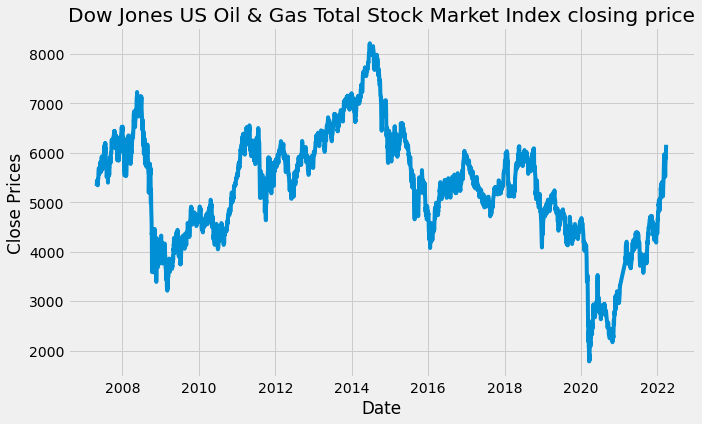

In [10]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(index_data['close'])
plt.title('Dow Jones US Oil & Gas Total Stock Market Index closing price')
plt.show()

In [12]:
# Get the "Closing Price" from the Index data
df_close = index_data[['close']]

<AxesSubplot:ylabel='Density'>

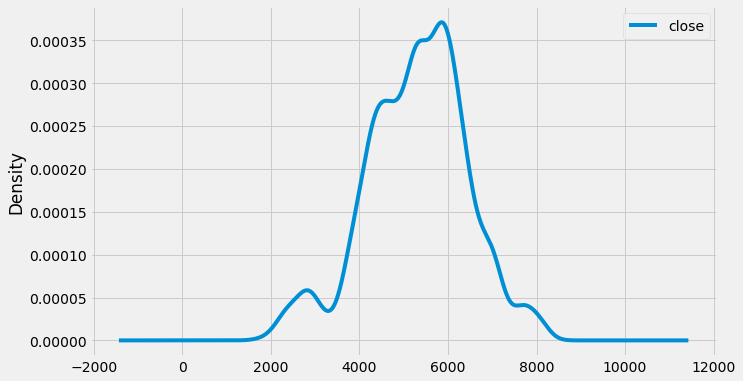

In [13]:
#Distribution of the dataset
df_close.plot(kind='kde')

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

**Null Hypothesis:** The series has a unit root (value of a =1)

**Alternate Hypothesis:** The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

**So let's check for stationarity:

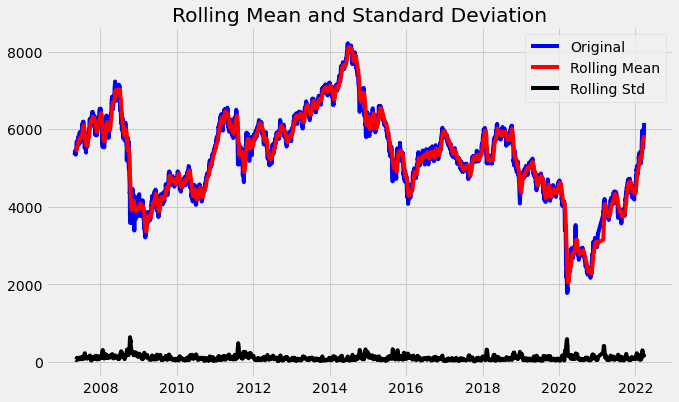

Results of dickey fuller test
Test Statistics                  -2.193120
p-value                           0.208752
No. of lags used                  1.000000
Number of observations used    3698.000000
critical value (1%)              -3.432120
critical value (5%)              -2.862322
critical value (10%)             -2.567186
dtype: float64


In [14]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

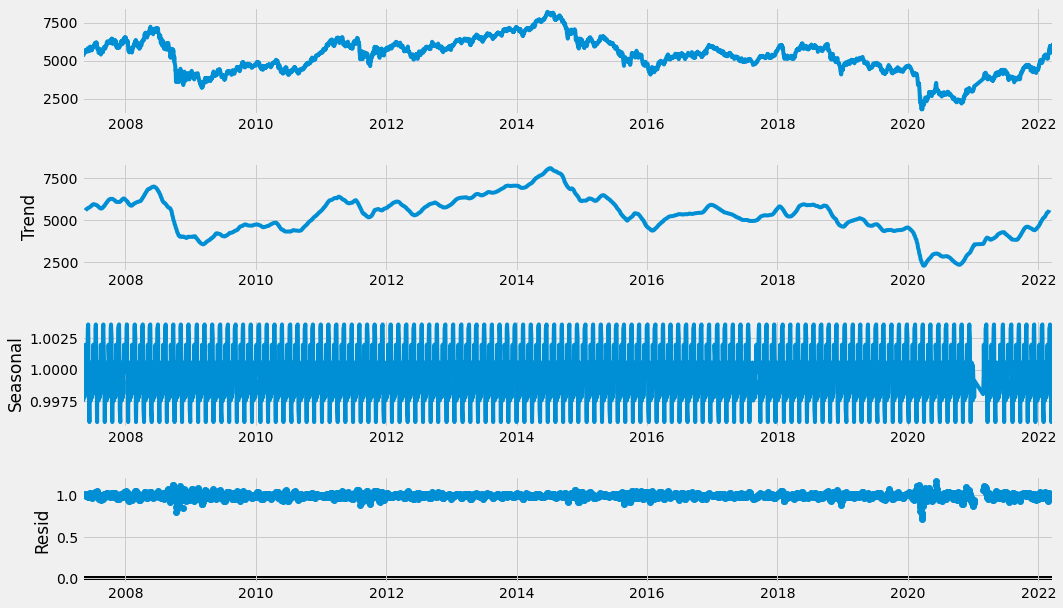

In [15]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


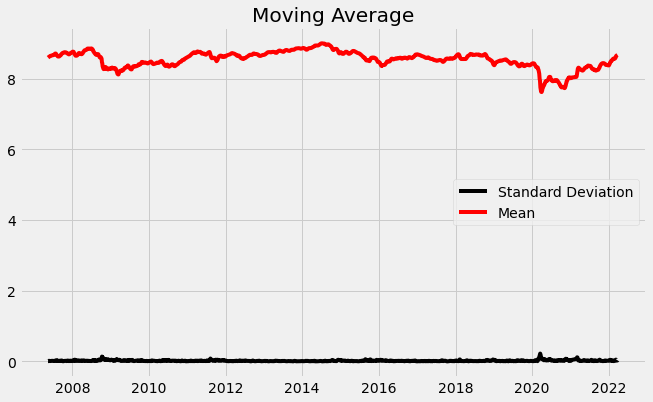

In [17]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

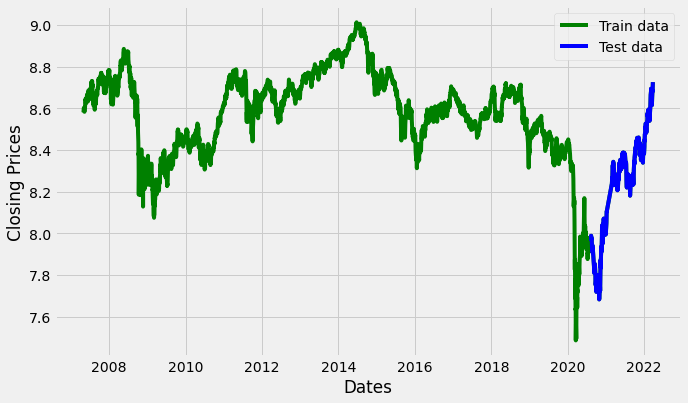

In [18]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

**Auto ARIMA: Automatically discover the optimal order for an ARIMA model.**
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.

The **auro_arima** function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16752.557, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16778.065, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16778.687, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16754.226, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16776.692, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16776.706, Time=1.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16776.218, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16780.280, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16778.286, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-16778.237, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16779.669, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16780.601, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-16782.245, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16776.679, Time=0.61 sec
 ARIM

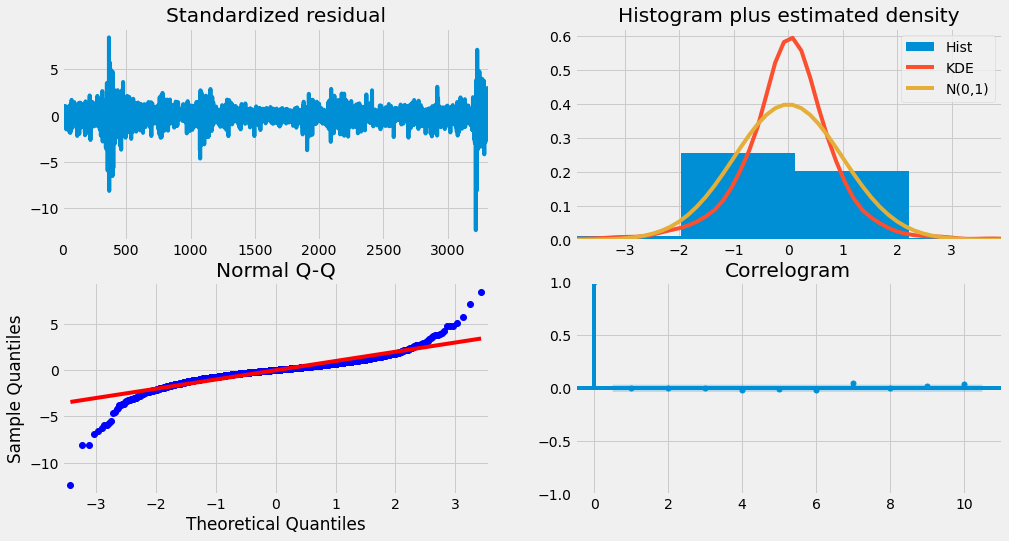

In [19]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 0, 1 and 3 respectively.**

In [20]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 3326
Model:                 ARIMA(0, 1, 3)   Log Likelihood                8396.360
Method:                       css-mle   S.D. of innovations              0.019
Date:                Fri, 25 Mar 2022   AIC                         -16782.719
Time:                        14:35:04   BIC                         -16752.172
Sample:                             1   HQIC                        -16771.789
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -0.606      0.545      -0.001       0.000
ma.L1.D.close    -0.0902      0.017     -5.207      0.000      -0.124      -0.056
ma.L2.D.close    -0.0066      0.018     

C:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [21]:
# Forecast
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

Plot the results

In [22]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: Length of values (321) does not match length of index (370)

In [23]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

ValueError: Found input variables with inconsistent numbers of samples: [370, 321]